# Análisis Optimizado de Subreddits
Implementación mejorada con:
- Preprocesamiento avanzado con NLTK
- Técnicas de balanceo de datos
- Ensemble de clasificadores
- Validación cruzada
- Optimización de hiperparámetros

In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder

# Imbalanced-learn para balanceo de datos
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Descargar recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\faboa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\faboa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\faboa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\faboa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
class RedditTextProcessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = RegexpTokenizer(r'\w+')
        self.stop_words = set(stopwords.words('english'))
        self.stop_words.update(['reddit', 'subreddit', 'post', 'edit', 'deleted'])
        
    def clean_text(self, text):
        """Limpieza básica del texto"""
        text = str(text).lower()
        text = text.replace('[removed]', '')
        text = text.replace('[deleted]', '')
        return text
    
    def preprocess_text(self, text):
        """Preprocesamiento completo del texto"""
        text = self.clean_text(text)
        tokens = self.tokenizer.tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens 
                  if token not in self.stop_words and len(token) > 2]
        return " ".join(tokens)
    
    def process_subreddit_data(self, json_file, min_posts=50):
        """Procesa los datos y filtra subreddits con pocos posts"""
        try:
            with open(json_file, 'r') as file:
                data = json.load(file)
        except FileNotFoundError:
            print(f"Error: The file {json_file} does not exist.")
            return pd.DataFrame()
        
        processed_posts = []
        
        for subreddit in data:
            subreddit_name = subreddit['tittleSubreddit']
            
            for post in subreddit['upVotedPosts']:
                full_text = f"{post.get('titlePost', '')} {post.get('selftext', '')}"
                processed_text = self.preprocess_text(full_text)
                
                if processed_text.strip():
                    processed_posts.append({
                        'subreddit': subreddit_name,
                        'processed_text': processed_text,
                        'created_utc': post['createdPost'],
                        'score': post['scorePost'],
                        'upvote_ratio': post['upVotedRatio'],
                        'comments': post['commentsPost']
                    })
        
        # Convert to DataFrame
        df = pd.DataFrame(processed_posts)
        
        # Filtrar subreddits con pocos posts
        subreddit_counts = df['subreddit'].value_counts()
        valid_subreddits = subreddit_counts[subreddit_counts >= min_posts].index
        df = df[df['subreddit'].isin(valid_subreddits)]
        
        return df


In [8]:
class RedditTopicAnalyzer:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=5
        )
        self.label_encoder = LabelEncoder()
        self.classifiers = self._create_classifiers()
        
    def _create_classifiers(self):
        """Crea un ensemble de clasificadores"""
        nb = MultinomialNB(alpha=0.1)
        svm = LinearSVC(C=1.0, class_weight='balanced')
        rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
        
        return VotingClassifier([
            ('nb', nb),
            ('svm', svm),
            ('rf', rf)
        ], voting='hard')
    
    def prepare_data(self, df):
        """Prepara los datos para el entrenamiento"""
        X = self.vectorizer.fit_transform(df['processed_text'])
        y = self.label_encoder.fit_transform(df['subreddit'])
        
        # Aplicar SMOTE para balance de clases
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        
        return train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        """Entrena y evalúa el ensemble de clasificadores"""
        # Entrenamiento
        self.classifiers.fit(X_train, y_train)
        
        # Predicciones
        y_pred = self.classifiers.predict(X_test)
        
        # Evaluación
        print("Resultados de la clasificación:")
        print(classification_report(
            y_test, 
            y_pred,
            target_names=self.label_encoder.classes_
        ))
        
        # Visualización de la matriz de confusión
        plt.figure(figsize=(15, 10))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', 
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
        plt.title('Matriz de Confusión')
        plt.xlabel('Predicción')
        plt.ylabel('Verdadero')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return {
            'accuracy': (y_pred == y_test).mean(),
            'confusion_matrix': cm
        }
    
    def analyze_feature_importance(self, subreddit_name):
        """Analiza las palabras más importantes para cada subreddit"""
        subreddit_idx = list(self.label_encoder.classes_).index(subreddit_name)
        
        # Obtener coeficientes del SVM
        svm = self.classifiers.named_estimators_['svm']
        feature_importance = svm.coef_[subreddit_idx]
        
        # Obtener las características más importantes
        feature_names = self.vectorizer.get_feature_names_out()
        top_features = sorted(zip(feature_importance, feature_names), reverse=True)[:20]
        
        # Visualización
        plt.figure(figsize=(12, 6))
        importance, words = zip(*top_features)
        plt.bar(words, importance)
        plt.title(f'Palabras más importantes para r/{subreddit_name}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

Resultados de la clasificación:
                       precision    recall  f1-score   support

            2007scape       0.34      0.32      0.33        63
                AITAH       0.45      0.66      0.53        56
        AmItheAsshole       0.50      0.87      0.63        60
               AskMen       0.30      0.52      0.38        62
            AskReddit       0.22      0.34      0.27        53
         BaldursGate3       0.23      0.28      0.25        58
             BeAmazed       0.08      0.11      0.09        54
BestofRedditorUpdates       0.61      0.94      0.74        63
   BlackPeopleTwitter       0.04      0.03      0.03        63
              ChatGPT       0.42      0.43      0.42        74
        CombatFootage       0.51      0.86      0.64        63
   CrazyFuckingVideos       0.10      0.11      0.10        61
        CuratedTumblr       0.09      0.23      0.13        64
                  DIY       0.44      0.53      0.48        78
 Damnthatsinteresting 

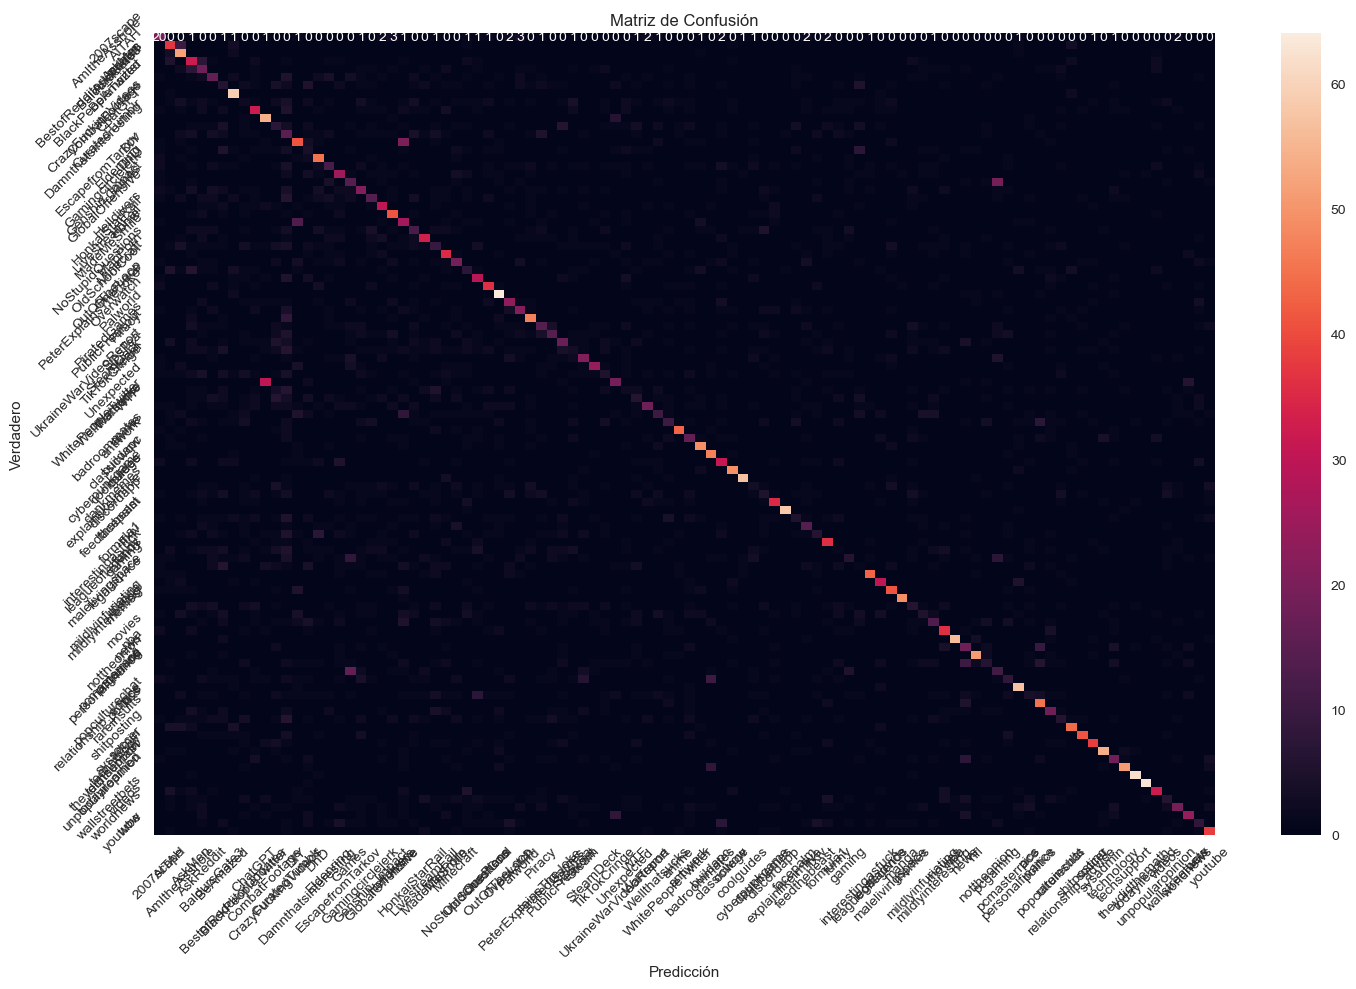

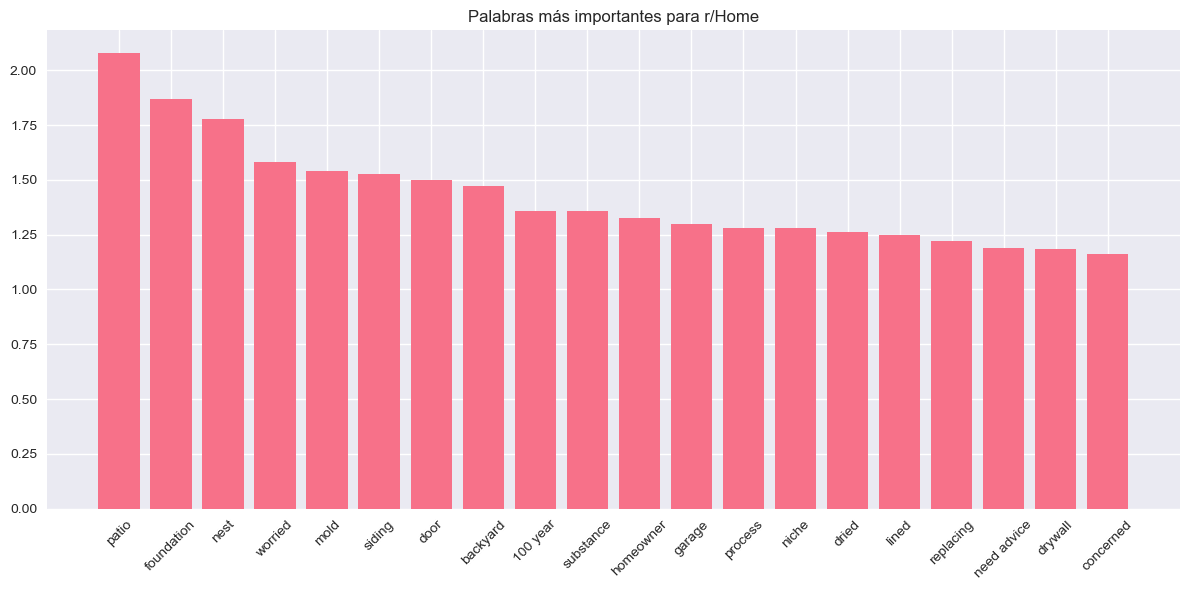

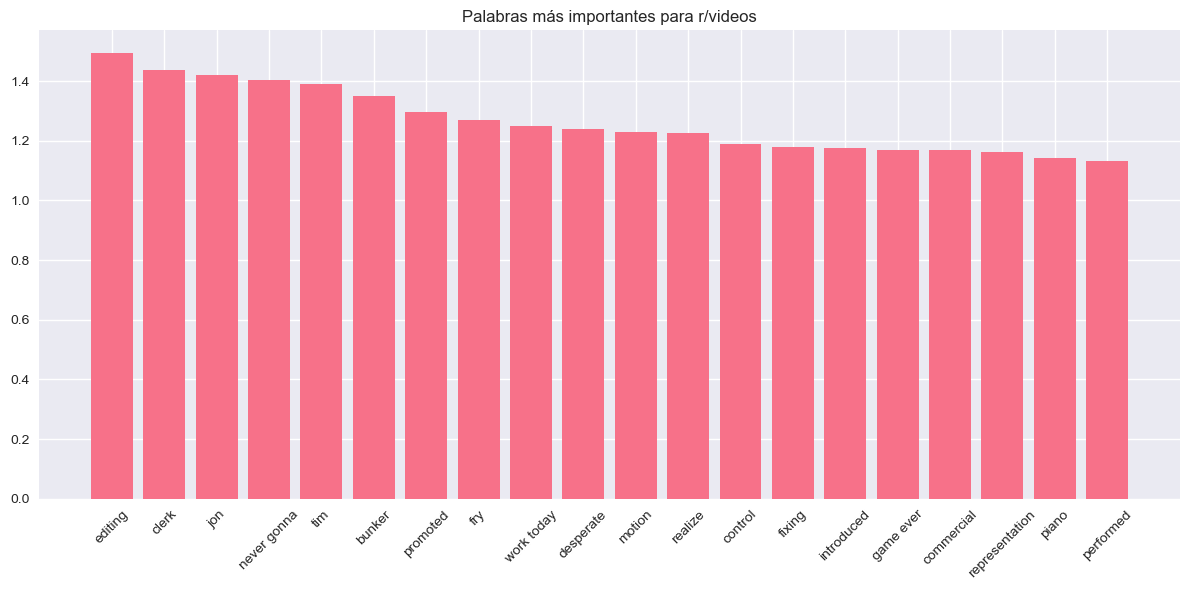

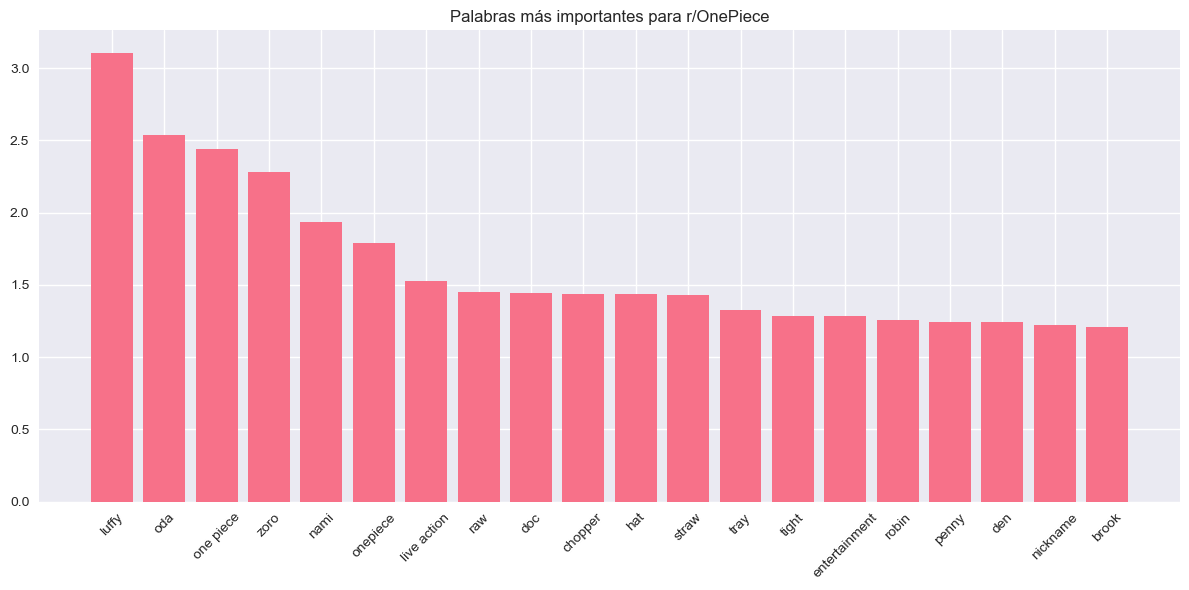

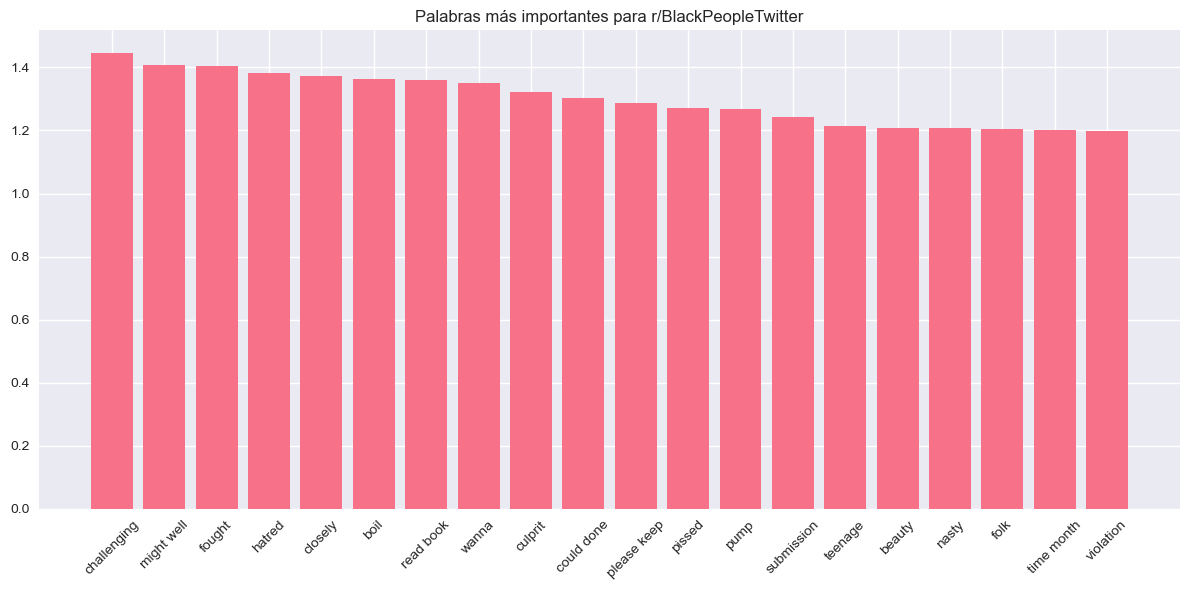

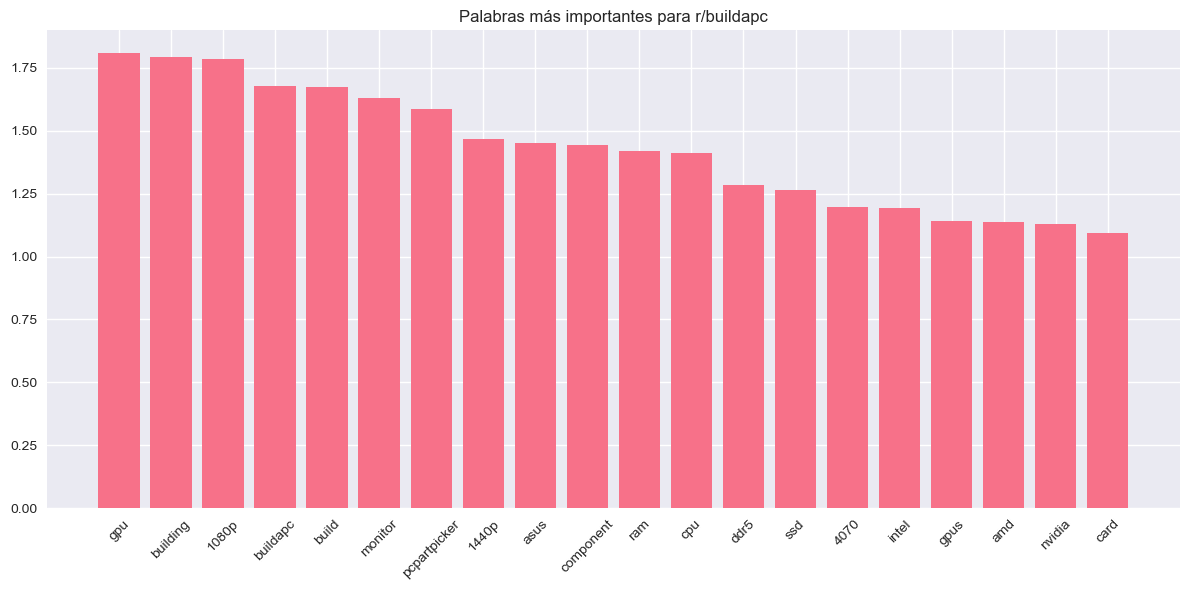

In [9]:
# Cargar y procesar datos
processor = RedditTextProcessor()
df = processor.process_subreddit_data('../data/subreddits.json', min_posts=50)

# Entrenar y evaluar el modelo
analyzer = RedditTopicAnalyzer()
X_train, X_test, y_train, y_test = analyzer.prepare_data(df)
results = analyzer.train_and_evaluate(X_train, X_test, y_train, y_test)

# Analizar características importantes para algunos subreddits populares
top_subreddits = df['subreddit'].value_counts().head(5).index
for subreddit in top_subreddits:
    analyzer.analyze_feature_importance(subreddit)